# reading HDF5 data file and understanding the dataset structure

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
path = '/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control.h5'

In [3]:
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['images', 'layer_maps', 'layer_names', 'patient_indices', 'splits']>

In [4]:
images = f['images']
layers = f['layer_maps']
splits = f['splits']
images, layers, splits

(<HDF5 dataset "images": shape (5088, 512, 1000), type "<f4">,
 <HDF5 dataset "layer_maps": shape (5088, 1000, 3), type "<f4">,
 <HDF5 group "/splits" (3 members)>)

In [5]:
print("Min:", np.nanmin(layers), "Max:", np.nanmax(layers))
print("Unique values:", np.unique(layers))
print("Any NaNs?", np.isnan(layers).any())
print("Shape:", layers.shape)

Min: 14.0 Max: 383.0
Unique values: [ 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200. 201. 202. 203. 

In [6]:
def plot_bscan_with_layers(idx):
    """Plot B-scan with layer annotations"""
    # Get data
    image = f['images'][idx]
    layers = f['layer_maps'][idx]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot B-scan
    plt.imshow(image, cmap='gray', aspect='auto')
    
    # Plot layer annotations
    x_coords = np.arange(1000)
    colors = ['red', 'green', 'blue']
    layer_names = [name.decode() for name in f['layer_names']]
    
    for i, (color, name) in enumerate(zip(colors, layer_names)):
        plt.plot(x_coords, layers[:, i], color=color, label=name, linewidth=1)
    
    plt.title(f'B-scan {idx} with Layer Annotations')
    plt.legend(loc='upper right')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

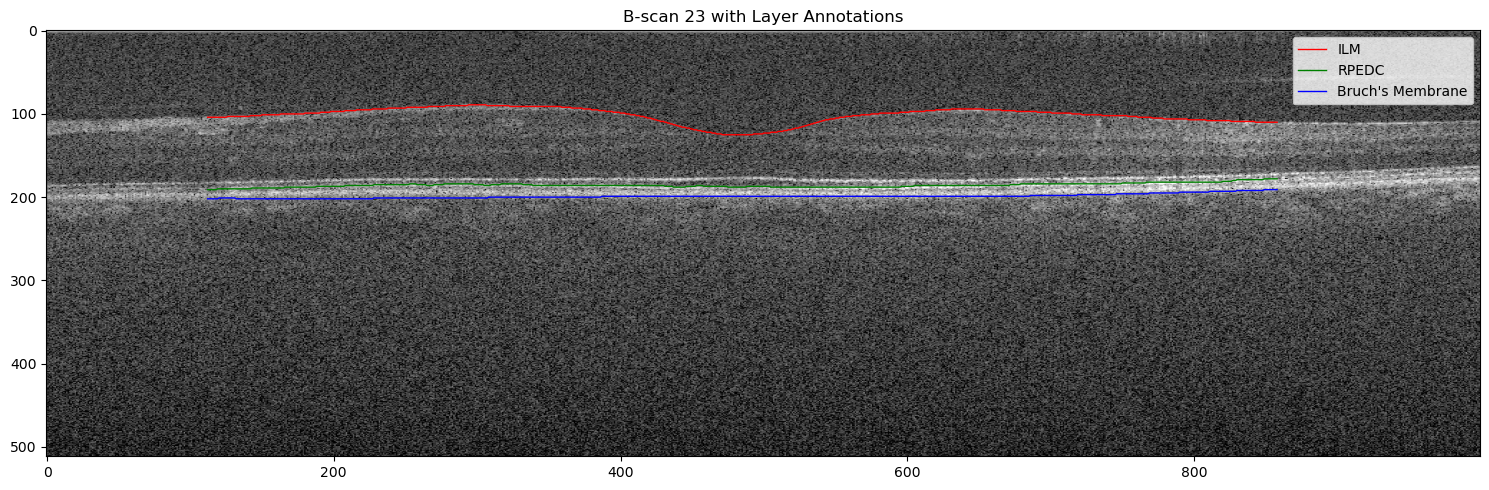

In [7]:

# Visualize a few examples
example_indices = [ 23]
for idx in example_indices:
    plot_bscan_with_layers(idx)

In [8]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2025-07-15 13:28:37.289269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752600517.301166   23965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752600517.305085   23965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 13:28:37.316315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.1


## Image Preprocessing Functions

In [9]:
def normalize_image(image):
    """
    Normalize pixel values to [0, 1] using min-max scaling
    """
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val == 0:
        return np.zeros_like(image, dtype=np.float32)
    normalized = (image - min_val) / (max_val - min_val)
    return normalized.astype(np.float32)

def crop_image(image, height_start=0, height_end=300):
    """
    Crop the image to focus on retinal area
    Keep full width (1000), crop height from 0 to 300
    """
    return image[height_start:height_end, :]

def preprocess_image(image):
    """
    Complete image preprocessing pipeline
    """
    # First crop, then normalize
    cropped = crop_image(image)
    normalized = normalize_image(cropped)
    return normalized

In [10]:
def preprocess_layer_maps(layer_maps, height_start=0, height_end=300):
    """
    Preprocess layer maps for segmentation task
    - Extract ILM and BM (first and third layers, skip RPE which is second)
    - Adjust coordinates for cropped image height
    - Return as (1000, 2) array for ILM and BM heights
    """
    # Extract ILM (layer 0) and BM (layer 2), skip RPE (layer 1)
    ilm_heights = layer_maps[:, 0]  # shape: (1000,)
    bm_heights = layer_maps[:, 2]   # shape: (1000,)
    
    # Adjust coordinates for cropped image (subtract height_start)
    ilm_adjusted = ilm_heights - height_start
    bm_adjusted = bm_heights - height_start
    
    # Clip to valid range [0, height_end - height_start]
    crop_height = height_end - height_start
    ilm_adjusted = np.clip(ilm_adjusted, 0, crop_height - 1)
    bm_adjusted = np.clip(bm_adjusted, 0, crop_height - 1)
    
    # Stack to create (1000, 2) array
    processed_layers = np.stack([ilm_adjusted, bm_adjusted], axis=1)
    
    return processed_layers.astype(np.float32)

In [11]:
def load_and_preprocess_data(num_samples=1000):
    """
    Load and preprocess the first num_samples images and layer maps
    """
    print(f"Loading and preprocessing {num_samples} samples...")
    
    # Load raw data
    raw_images = f['images'][:num_samples]
    raw_layer_maps = f['layer_maps'][:num_samples]
    
    # Initialize arrays for processed data
    processed_images = []
    processed_layer_maps = []
    
    # Process each sample
    for i in range(num_samples):
        # Preprocess image
        img = preprocess_image(raw_images[i])
        processed_images.append(img)
        
        # Preprocess layer maps
        layers = preprocess_layer_maps(raw_layer_maps[i])
        processed_layer_maps.append(layers)
        
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{num_samples} samples")
    
    # Convert to numpy arrays
    processed_images = np.array(processed_images)
    processed_layer_maps = np.array(processed_layer_maps)
    
    print(f"Processed images shape: {processed_images.shape}")
    print(f"Processed layer maps shape: {processed_layer_maps.shape}")
    
    return processed_images, processed_layer_maps

def split_data(images, layer_maps, train_split=0.9):
    """
    Split data into train and test sets
    """
    num_samples = len(images)
    train_size = int(num_samples * train_split)
    
    # Split the data
    train_images = images[:train_size]
    train_layer_maps = layer_maps[:train_size]
    test_images = images[train_size:]
    test_layer_maps = layer_maps[train_size:]
    
    print(f"Train set: {len(train_images)} samples")
    print(f"Test set: {len(test_images)} samples")
    
    return train_images, train_layer_maps, test_images, test_layer_maps

## Load and Preprocess Data

In [14]:
# Load and preprocess the data
processed_images, processed_layer_maps = load_and_preprocess_data(num_samples=1000)

# Split into train and test sets
train_images, train_layer_maps, test_images, test_layer_maps = split_data(
    processed_images, processed_layer_maps, train_split=0.9
)

Loading and preprocessing 1000 samples...
Processed 100/1000 samples
Processed 200/1000 samples
Processed 300/1000 samples
Processed 400/1000 samples
Processed 500/1000 samples
Processed 600/1000 samples
Processed 700/1000 samples
Processed 800/1000 samples
Processed 900/1000 samples
Processed 1000/1000 samples
Processed images shape: (1000, 300, 1000)
Processed layer maps shape: (1000, 1000, 2)
Train set: 900 samples
Test set: 100 samples


In [20]:
# Import required libraries for model building
# Use tf.keras which is the correct way in TensorFlow 2.x
import json

# Add channel dimension to images (for CNN input)
train_images_reshaped = np.expand_dims(train_images, axis=-1)  # Shape: (900, 300, 1000, 1)
test_images_reshaped = np.expand_dims(test_images, axis=-1)    # Shape: (100, 300, 1000, 1)

# Convert to TensorFlow tensors
train_images_tf = tf.convert_to_tensor(train_images_reshaped, dtype=tf.float32)
train_layer_maps_tf = tf.convert_to_tensor(train_layer_maps, dtype=tf.float32)
test_images_tf = tf.convert_to_tensor(test_images_reshaped, dtype=tf.float32)
test_layer_maps_tf = tf.convert_to_tensor(test_layer_maps, dtype=tf.float32)

print("TensorFlow tensor shapes:")
print(f"Train images: {train_images_tf.shape}")
print(f"Train layer maps: {train_layer_maps_tf.shape}")
print(f"Test images: {test_images_tf.shape}")
print(f"Test layer maps: {test_layer_maps_tf.shape}")
print(f"Image dtype: {train_images_tf.dtype}")
print(f"Layer maps dtype: {train_layer_maps_tf.dtype}")

# Validate data ranges
print(f"\nData Validation:")
print(f"Image range: [{tf.reduce_min(train_images_tf):.3f}, {tf.reduce_max(train_images_tf):.3f}]")
print(f"Layer map range: [{tf.reduce_min(train_layer_maps_tf):.1f}, {tf.reduce_max(train_layer_maps_tf):.1f}]")

# Check for any problematic values
print(f"Any NaN in images: {tf.reduce_any(tf.math.is_nan(train_images_tf))}")
print(f"Any NaN in layer maps: {tf.reduce_any(tf.math.is_nan(train_layer_maps_tf))}")
print(f"Any infinite values in images: {tf.reduce_any(tf.math.is_inf(train_images_tf))}")
print(f"Any infinite values in layer maps: {tf.reduce_any(tf.math.is_inf(train_layer_maps_tf))}")

2025-07-15 13:41:22.572020: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1080000000 exceeds 10% of free system memory.
2025-07-15 13:41:32.961289: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1080000000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-15 13:41:32.961358: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-07-15 13:41:32.961381: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-07-15 13:41:32.961399: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (51

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.